In [87]:
#Let's start by implementing the Probabilistic PCA approach for the single model case

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [88]:
import numpy as np

def ppca(data, q):
    """
    Implements Probabilistic PCA (PPCA) using the closed-form solution.
    
    Parameters:
    - data (numpy.ndarray): The input data of shape (n_samples, n_features).
    - q (int): Dimensionality of the latent space.
    
    Returns:
    - W_hat (numpy.ndarray): The projection matrix of shape (n_features, q).
    - mu_hat (numpy.ndarray): The mean vector of shape (n_features,).
    - sigma_hat (float): The estimated noise variance.
    """
    n, d = data.shape

    # Compute sample mean
    mu_hat = np.mean(data, axis=0)

    # Center the data
    data = data - mu_hat

    # Compute sample covariance matrix
    S = (1 / n) * np.dot(data.T, data)

    # Eigen decomposition of the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(S)

    # Sort eigenvectors by decreasing eigenvalues
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Select the top q components
    U = eigvecs[:, :q]  # Top-q eigenvectors
    Lambda = eigvals[:q]  # Top-q eigenvalues as a diagonal matrix

    # Compute sigma_hat (noise variance)
    if q < d:
        sigma_hat = (1 / (d - q)) * np.sum(eigvals[q:])
    else:
        # Avoid division by zero if q == d (fully ranked PCA)
        sigma_hat = 0.0

    # Compute W_hat (projection matrix)
    W_hat = U @ np.sqrt(Lambda - sigma_hat * np.eye(q))

    return W_hat, mu_hat, sigma_hat

In [89]:
import numpy as np


class PPCA:
    def __init__(self, n_components, max_iter=1000, tol=1e-6, verbose=False, random_state=None):
        """
        Probabilistic PCA using EM algorithm.

        Parameters:
        - n_components: Number of principal components (latent dimensions).
        - max_iter: Maximum number of EM iterations.
        - tol: Convergence tolerance for parameter updates.
        - verbose: Whether to print progress during training.
        - random_state: Random seed for reproducibility.
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.rng = np.random.default_rng(random_state)

    def fit(self, X):
        """
        Fit the PPCA model using the EM algorithm.

        Parameters:
        - X: (n_samples, n_features) input data matrix.

        Returns:
        - self: The fitted PPCA model.
        """
        X = np.asarray(X)
        n_samples, n_features = X.shape

        if self.n_components >= min(n_samples, n_features):
            raise ValueError("n_components must be less than min(n_samples, n_features).")

        # Initialize parameters
        self.mean_ = np.mean(X, axis=0)
        centered_data = X - self.mean_
        W = self.rng.normal(size=(n_features, self.n_components))
        sigma2 = 1.0

        for iteration in range(self.max_iter):
            # E-step: Compute posterior expectations
            M = W.T @ W + sigma2 * np.eye(self.n_components)
            M_inv = np.linalg.inv(M)
            Ez = centered_data @ W @ M_inv  # Posterior mean of latent variables
            Ezz = sigma2 * M_inv + np.einsum('ni,nj->nij', Ez, Ez)  # Posterior covariance

            # M-step: Update parameters
            W_new = centered_data.T @ Ez @ np.linalg.inv(np.sum(Ezz, axis=0))
            sigma2_new = (
                np.mean(np.sum(centered_data**2, axis=1))
                - 2 * np.mean(np.sum(Ez @ W_new.T * centered_data, axis=1))
                + np.trace(np.sum(Ezz, axis=0) @ (W_new.T @ W_new))
            ) / n_features

            # Convergence check
            if (
                np.linalg.norm(W_new - W) < self.tol
                and abs(sigma2_new - sigma2) < self.tol
            ):
                if self.verbose:
                    print(f"Converged after {iteration + 1} iterations.")
                break

            W, sigma2 = W_new, sigma2_new

        self.W_ = W
        self.noise_variance_ = sigma2
        self.components_ = W.T
        return self

    def transform(self, X):
        """
        Transform the input data to the latent space.

        Parameters:
        - X: (n_samples, n_features) input data matrix.

        Returns:
        - Z: (n_samples, n_components) latent variable representations.
        """
        X = np.asarray(X)
        centered_data = X - self.mean_
        M = self.W_.T @ self.W_ + self.noise_variance_ * np.eye(self.n_components)
        M_inv = np.linalg.inv(M)
        return (centered_data @ self.W_ @ M_inv)

    def fit_transform(self, X):
        """
        Fit the PPCA model and transform the data to the latent space.

        Parameters:
        - X: (n_samples, n_features) input data matrix.

        Returns:
        - Z: (n_samples, n_components) latent variable representations.
        """
        return self.fit(X).transform(X)

    def reconstruct(self, Z):
        """
        Reconstruct data from the latent space.

        Parameters:
        - Z: (n_samples, n_components) latent variable representations.

        Returns:
        - X_hat: (n_samples, n_features) reconstructed data.
        """
        return Z @ self.W_.T + self.mean_

    def log_likelihood(self, X):
        """
        Compute the log likelihood of the data under the PPCA model.

        Parameters:
        - X: (n_samples, n_features) input data matrix.

        Returns:
        - ll: Log likelihood of the data.
        """
        X = np.asarray(X)
        centered_data = X - self.mean_
        n_samples, n_features = X.shape
        M = self.W_.T @ self.W_ + self.noise_variance_ * np.eye(self.n_components)
        C_inv = np.eye(n_features) / self.noise_variance_ - self.W_ @ np.linalg.inv(M) @ self.W_.T / self.noise_variance_
        ll = -0.5 * (
            n_samples * n_features * np.log(2 * np.pi)
            + n_samples * np.linalg.slogdet(C_inv)[1]
            + np.sum(np.square(centered_data) @ C_inv)
        )
        return ll



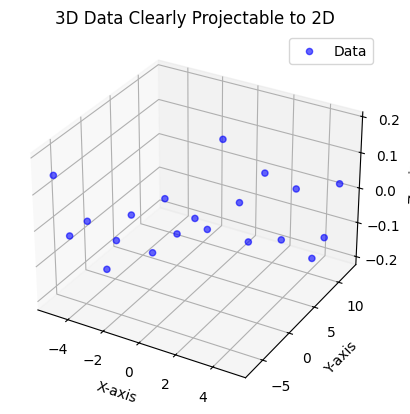

In [90]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate points in a 2D plane
n_samples = 20
x = np.linspace(-5, 5, n_samples)  # First latent dimension
y = 2 * x + 3 + np.random.normal(scale=0.5, size=n_samples)  # Second latent dimension with noise
z = np.random.normal(scale=0.1, size=n_samples)  # Small noise in the orthogonal direction

# Stack the data into a 3D array
data = np.stack([x, y, z], axis=1)

# Plot the generated data in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.6, c='blue', label="Data")
ax.set_title("3D Data Clearly Projectable to 2D")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()


Time taken for PPCA (analytical): 0.0024318695068359375
Time taken for EM-PPCA: 0.010738849639892578


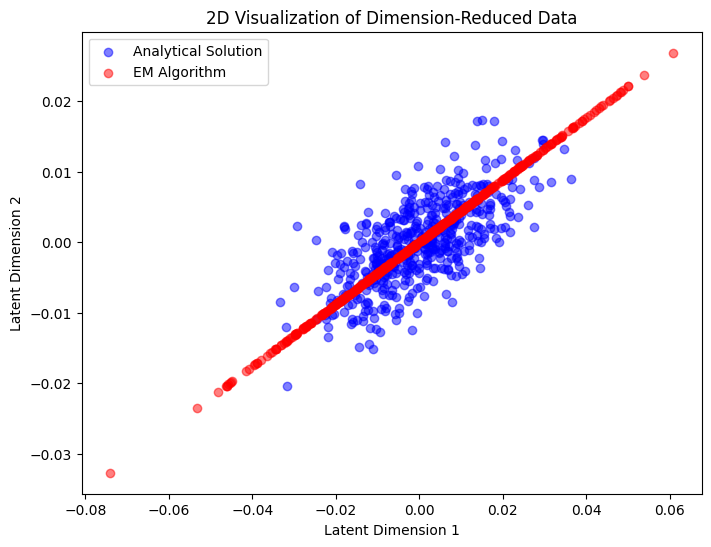

Analytical W:
 [[ 0.83500086  0.07331606]
 [-0.49140183  0.15704392]
 [-0.98083662 -0.64264708]]
Analytical mu:
 [ 0.11458187 -0.02788917  0.06045594]
Analytical sigma^2: 112.65781511505615

EM W:
 [[ 0.00059851  0.00026143]
 [-0.00909114 -0.00400285]
 [-0.01968832 -0.0086886 ]]
EM mu:
 [ 0.11458187 -0.02788917  0.06045594]
EM sigma^2: 1.0697688226343272


In [93]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Generate synthetic data for testing
np.random.seed(42)
n_samples, n_features = 500, 3
data = np.random.randn(n_samples, n_features)

# Number of latent dimensions
q = 2

# Analytical PPCA using the PPCA class
start = time.time()
ppca_analytical = PPCA(n_components=q, max_iter=1, tol=1e-6)  # One iteration mimics analytical solution
Z_analytical = ppca_analytical.fit_transform(data)
end = time.time()
print("Time taken for PPCA (analytical):", end - start)

# Extract parameters for debugging
W_analytical = ppca_analytical.W_
mu_analytical = ppca_analytical.mean_
sigma2_analytical = ppca_analytical.noise_variance_

# EM-PPCA using the PPCA class
start = time.time()
ppca_em = PPCA(n_components=q, max_iter=100, tol=1e-6, verbose=True, random_state=42)  # Full EM optimization
Z_em = ppca_em.fit_transform(data)
end = time.time()
print("Time taken for EM-PPCA:", end - start)

# Extract parameters for debugging
W_em = ppca_em.W_
mu_em = ppca_em.mean_
sigma2_em = ppca_em.noise_variance_

# 2D Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Z_analytical[:, 0], Z_analytical[:, 1], c='blue', alpha=0.5, label="Analytical Solution")
plt.scatter(Z_em[:, 0], Z_em[:, 1], c='red', alpha=0.5, label="EM Algorithm")
plt.title("2D Visualization of Dimension-Reduced Data")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

# Debugging outputs
print("Analytical W:\n", W_analytical)
print("Analytical mu:\n", mu_analytical)
print("Analytical sigma^2:", sigma2_analytical)
print("\nEM W:\n", W_em)
print("EM mu:\n", mu_em)
print("EM sigma^2:", sigma2_em)



In [92]:
print("Analytical W:", W)
print("Analytical sigma2:", sigma2)
print("EM W:", W_em)
print("EM sigma2:", sigma2_em)

print("Analytical Z mean:", np.mean(Z, axis=0))
print("Analytical Z variance:", np.var(Z, axis=0))
print("EM Z_em mean:", np.mean(Z_em, axis=0))
print("EM Z_em variance:", np.var(Z_em, axis=0))



Analytical W: [[-8.64531282 -0.2143604 ]
 [-2.86253981 -0.08633843]
 [-1.60412144 -0.03789934]]
Analytical sigma2: 0.006926611003530533
EM W: [[-2.63616448e+00  2.16259481e-17]
 [-5.03907467e+00  4.13383794e-17]
 [ 1.93287222e-02 -1.58564440e-19]]
EM sigma2: 10.415858840970392
Analytical Z mean: [1.94289029e-17 0.00000000e+00]
Analytical Z variance: [6.66203418e-02 9.22340869e+01]
EM Z_em mean: [ 1.11022302e-17 -2.31111593e-34]
EM Z_em variance: [7.56398681e-01 5.09044875e-35]


In [96]:

class PPCA:
    """Probabilistic Principle Component Analysis (PPCA).
    PPCA is a probabilistic latent variable model, whose maximum likelihood
    solution corresponds to PCA. For an introduction to PPCA, see [1].

    This implementation uses the expectation-maximization (EM) algorithm to
    find maximum-likelihood estimates of the PPCA model parameters. This
    enables a principled handling of missing values in the dataset, assuming
    that the values are missing at random.

      p(z) = N(0, I)
    p(x|z) = N(W.T @ z + mean, noise_variance * I)


    Attributes:

    W_ : (ndarray of shape (n_components, n_features))
        Principal axes in feature space, representing the
        directions of maximum variance in the data, scaled
        by the square root of a noise-adjusted variance
        parameter. The components are sorted by decreasing
        explained_variance_.

    mean_ : (ndarray of shape (n_features,))
        Per-feature empirical mean, estimated from the training set.

    noise_variance_ : (float)
        The estimated noise variance of the conditional distribution.

    explained_variance_ : (ndarray of shape (n_components,))
        The amount of variance explained by each of the
        selected components. The variance estimation
        uses n_samples degrees of freedom.

    explained_variance_ratio_ : (ndarray of shape (n_components,))
        Percentage of variance explained by each
        of the selected components.

    n_components_ : (int)
        The number of components.

    n_samples_ : (int)
        Number of samples in the training data.

    n_features_in_ : (int)
        Number of features seen during fit.

    References:
    [1] Bishop, C. M., Pattern Recognition and Machine Learning. New York:
        Springer, 2006.
    [2] Tipping, M. E. and Bishop, C. M., Probabilistic Principal Component
        Analysis. Journal of the Royal Statistical Society: Series B
        (Statistical Methodology), 1999.
    """

    def __init__(
        self,
        n_components: int,
        max_iter: int = 10000,
        min_iter: int = 20,
        rtol: float = 1e-6,
        verbose: bool = False,
        random_state: int | None = None,
    ):
        """Initialize a PPCA model.

        Parameters:

        n_components : (int)
            Number of components to estimate. Has to be smaller than
            min(n_features, n_samples).
        max_iter : (int)
            Maximum number of iterations to run EM algorithm.
        min_iter : (int)
            Minimum number of iterations to run EM algorithm.
        rtol : (float)
            Convergence criterion for EM: relative change in parameters
            and complete-data negative log likelihood.
        verbose : (bool)
            Whether to print convergence info.
        random_state : (int)
            Fix a random seed to replicate EM initial conditions.
        """
        if rtol <= 0:
            raise ValueError("rtol must be greater than zero")

        self.n_components_ = n_components
        self.max_iter = max_iter
        self.min_iter = min_iter
        self.rtol = rtol
        self.verbose = verbose
        self.rng = np.random.default_rng(random_state)

    def fit(self, X: np.ndarray):
        """Maximum likelihood estimation of model parameters using
        the EM algorithm.

        Parameters:

        X : (ndarray of shape (n_samples, n_features))
            observations

        Returns:

        ppca : (PPCA)
            fitted PPCA model
        """
        # code expects X as (n_features, n_samples)
        X = X.T

        self.n_features_in_, self.n_samples_ = X.shape
        max_rank = min(self.n_features_in_, self.n_samples_)
        if self.n_components_ > max_rank - 1:
            raise ValueError(
                "For PPCA, n_components (= {0}) has to be smaller than min(n_samples, n_features) (= {1}).".format(
                    self.n_components_, max_rank
                )
            )

        if np.any(np.all(np.isnan(X), axis=0)):
            raise ValueError(
                "X contains observations which are entirely NaN. Please remove those before running PPCA."
            )

        W, mu, sig2 = self._em(X)

        # rotate W to the standard PCA basis
        PC, scale, _ = np.linalg.svd(W, full_matrices=False)
        # the largest element in each principle component will have a positive sign
        max_abs_u_cols = np.argmax(np.abs(PC), axis=0)
        shift = np.arange(PC.shape[1])
        indices = max_abs_u_cols + shift * PC.shape[0]
        signs = np.sign(np.take(np.reshape(PC.T, (-1,)), indices, axis=0))
        PC *= signs[np.newaxis, :]
        W = PC @ np.diag(scale)

        # in scikit-learn the variance estimation uses n_samples - 1 degrees of freedom
        # but here we use n_samples degrees of freedom
        self.explained_variance_ = scale**2 + sig2
        self.explained_variance_ratio_ = self.explained_variance_ / (
            sum(self.explained_variance_)
            + sig2 * (self.n_features_in_ - self.n_components_)
        )

        self.W_ = W.T
        self.mean_ = mu
        self.noise_variance_ = sig2

        return self

    def transform(self, X: np.ndarray, return_cov=False, noise_free=False):
        """Transform observations by computing their latent variable
        posterior.

        Parameters:

        X : (ndarray of shape (n_samples, n_features))
            observations
        return_cov : (bool)
            whether to return the covariance matrix
        noise_free : (bool)
            whether to assume sig2 = 0

        Returns:

        Z : (ndarray of shape (n_samples, n_components))
            mean of latent variables
        covZ : (ndarray of shape (n_samples, n_components, n_components)), optional
            covariance matrix of latent variables
        """
        # code expects X as (n_features, n_samples)
        X = X.T
        W = self.W_.T
        sig2 = self.noise_variance_ if not noise_free else 0
        Xc = X - self.mean_[:, None]

        obs = ~np.isnan(Xc)
        if np.all(obs):
            # columns of W are orthogonal
            M_inv = np.diag(1 / (np.diag(W.T @ W) + sig2))
            Z = (M_inv @ W.T @ Xc).T
            covZ = np.tile(sig2 * M_inv[None, :, :], (X.shape[1], 1, 1))
        else:
            Z = np.zeros((self.n_samples_, self.n_components_))
            covZ = np.zeros((self.n_samples_, self.n_components_, self.n_components_))
            for n in range(self.n_samples_):
                w = W[obs[:, n], :]
                m_inv = np.linalg.inv(sig2 * np.eye(self.n_components_) + w.T @ w)
                Z[n, :] = m_inv @ w.T @ Xc[obs[:, n], n]
                covZ[n, :, :] = sig2 * m_inv
        if return_cov:
            return Z, covZ
        return Z

    def fit_transform(self, X: np.ndarray, return_cov=False, noise_free=False):
        """Combine `fit` and `transform`.

        Parameters:

        X : (ndarray of shape (n_samples, n_features))
            observations
        return_cov : (bool)
            whether to return the covariance matrix
        noise_free : (bool)
            whether to assume sig2 = 0

        Returns:

        Z : (ndarray of shape (n_samples, n_components))
            mean of latent variables
        covZ : (ndarray of shape (n_samples, n_components, n_components)), optional
            covariance matrix of latent variables
        """
        return self.fit(X).transform(X, return_cov, noise_free)

    def log_likelihood(self, X, reduction="sum"):
        """Compute the data log likelihood.

        Parameters:

        X : (ndarray of shape (n_samples, n_features))
            observations
        reduction : (str)
            reduce option for log likelihood

        Returns:

        ll : (ndarray of shape (n_samples,) or float)
            data log likelihood
        """
        # code expects X as (n_features, n_samples)
        X = X.T
        W = self.W_.T
        sig2 = self.noise_variance_
        Xc = X - self.mean_[:, None]
        ll = -self._compute_nll(Xc, W, sig2)
        if reduction == "sum":
            return sum(ll)
        return ll

    def reconstruct(self, Z, orthogonal=False):
        """Reconstruct observations from latent variables.

        Parameters:

        Z : (ndarray of shape (n_samples, n_components))
            latent variables
        orthogonal : (bool)
            whether to reconstruct using orthogonal projection

        Returns:

        X_hat : (ndarray of shape (n_samples, n_features))
            reconstructed observations
        """
        # code expects Z as (n_components, n_samples)
        Z = Z.T
        W = self.W_.T
        sig2 = self.noise_variance_
        if orthogonal:
            # optimal reconstruction in the squared reconstruction error sense
            # for the case sig2 > 0
            X_hat = (
                W @ np.diag(1 / np.diag(W.T @ W)) @ np.diag(np.diag(W.T @ W) + sig2) @ Z
                + self.mean_[:, None]
            ).T
        else:
            X_hat = (W @ Z + self.mean_[:, None]).T
        return X_hat

    def _em(self, X: np.ndarray):
        """Expectation-maximization (EM) algorithm for PPCA.

        Parameters:

        X : (ndarray of shape (n_samples, n_features))
            observations

        Returns:

        W : (ndarray of shape (n_features, n_components))
            transformation matrix
        mu : (ndarray of shape (n_features,))
            mean vector
        sig2 : (float)
            variance parameter
        """
        W = self.rng.randn(self.n_features_in_, self.n_components_)
        mu = np.nanmean(X, axis=1)
        sig2 = self.rng.randn()
        nll = np.inf

        Xc = X - mu[:, None]

        if self.verbose:
            print("{0: >11} {1: >27}".format("Iteration", "Negative log-likelihood"))
            strfmt = "{0: >11d} {1: >27f}"

        itercount = 0
        while itercount < self.max_iter:
            itercount += 1

            Ez, Ezz = self._e_step(Xc, W, sig2)
            W_new, sig2_new = self._m_step(Xc, Ez, Ezz)

            nll_new = sum(self._compute_nll(Xc, W_new, sig2_new))

            if self.verbose and (itercount % 20 == 0):
                print(strfmt.format(itercount, nll_new))

            if itercount > self.min_iter:
                if np.allclose(W_new, W, rtol=self.rtol, atol=0) and np.allclose(
                    sig2_new, sig2, rtol=self.rtol, atol=0
                ):
                    break
                elif np.allclose(nll_new, nll, rtol=self.rtol, atol=0):
                    break

            W = W_new
            sig2 = sig2_new
            nll = nll_new

            if itercount == self.max_iter:
                raise RuntimeError(
                    "Maximum number of iterations reached without convergence: {}".format(
                        self.max_iter
                    )
                )

        return W_new, mu, sig2_new

    def _e_step(
        self,
        Xc: np.ndarray,
        W: np.ndarray,
        sig2: float,
    ):
        """Expectation step of EM algorithm for PPCA.

        Parameters:

        Xc : (ndarray of shape (n_samples, n_features))
            centered observations
        W : (ndarray of shape (n_features, n_components))
            transformation matrix
        sig2 : (float)
            variance parameter

        Returns:

        Ez : (ndarray of shape (n_components, n_samples))
            posterior mean of latent variables
        Ezz : (ndarray of shape (n_components, n_components, n_samples))
            posterior covariance matrix of latent variables
        """
        obs = ~np.isnan(Xc)
        if np.all(obs):
            M_inv = np.linalg.inv(W.T @ W + sig2 * np.eye(self.n_components_))
            Ez = M_inv @ W.T @ Xc
            Ezz = sig2 * M_inv[:, :, None] + Ez[:, None, :] * Ez[None, :, :]
        else:
            Ez = np.zeros((self.n_components_, self.n_samples_))
            Ezz = np.zeros((self.n_components_, self.n_components_, self.n_samples_))
            for n in range(self.n_samples_):
                w = W[obs[:, n], :]
                m_inv = np.linalg.inv(sig2 * np.eye(self.n_components_) + w.T @ w)
                Ez[:, n] = m_inv @ w.T @ Xc[obs[:, n], n]
                Ezz[:, :, n] = sig2 * m_inv + Ez[:, None, n] * Ez[None, :, n]
        return Ez, Ezz

    def _m_step(
        self,
        Xc: np.ndarray,
        Ez: np.ndarray,
        Ezz: np.ndarray,
    ):
        """Maximization step of EM algorithm for PPCA.

        Parameters:

        Xc : (ndarray of shape (n_samples, n_features))
            centered observations
        Ez : (ndarray of shape (n_components, n_samples))
            posterior mean of latent variables
        Ezz : (ndarray of shape (n_components, n_components, n_samples))
            posterior covariance matrix of latent variables

        Returns:

        W : (ndarray of shape (n_features, n_components))
            transformation matrix
        sig2 : (float)
            variance parameter
        """
        obs = ~np.isnan(Xc)
        if np.all(obs):
            W_new = np.linalg.solve(
                np.sum(Ezz, axis=2),
                Ez @ Xc.T,
            ).T
            sig2_new = (
                np.mean(np.square(Xc))
                - np.mean(2 * Xc * (W_new @ Ez))
                + np.sum(Ezz * (W_new.T @ W_new)[:, :, None])
                / (self.n_features_in_ * self.n_samples_)
            )

        else:
            W_new = np.zeros((self.n_features_in_, self.n_components_))
            for i in range(self.n_features_in_):
                idx_obs = obs[i, :]
                W_new[i, :] = np.linalg.solve(
                    np.sum(Ezz[:, :, idx_obs], axis=2), Ez[:, idx_obs] @ Xc[i, idx_obs]
                )
            sig2_sum = 0
            for n in range(self.n_samples_):
                w_new = W_new[obs[:, n], :]
                sig2_sum += (
                    np.sum(np.square(Xc[obs[:, n], n]))
                    - 2 * Ez[:, n] @ w_new.T @ Xc[obs[:, n], n]
                    + np.sum(w_new.T * (Ezz[:, :, n] @ w_new.T))
                )
            sig2_new = sig2_sum / np.sum(obs)
        return W_new, sig2_new

    def _compute_nll(
        self,
        Xc: np.ndarray,
        W: np.ndarray,
        sig2: float,
    ):
        """Compute negative log likelihood under the current model.

        Parameters:

        Xc : (andarray of shape (n_samples, n_features))
            centered observations
        W : (ndarray of shape (n_features, n_components))
            transformation matrix
        sig2 : (float)
            variance parameter

        Returns:

        nll : (ndarray of shape (n_samples,))
            negative log likelihood of observations
        """
        obs = ~np.isnan(Xc)
        if np.all(obs):
            # use the matrix inversion lemma (because n_components < n_features)
            M = W.T @ W + sig2 * np.eye(self.n_components_)
            C_inv = (
                np.eye(self.n_features_in_) / sig2 - W @ np.linalg.solve(M, W.T) / sig2
            )
            nll = (
                self.n_features_in_ * np.log(2 * np.pi)
                - np.linalg.slogdet(C_inv)[1]
                + np.sum(Xc.T * (Xc.T @ C_inv), axis=1)
            ) / 2
        else:
            nll = np.zeros(self.n_samples_)
            for n in range(self.n_samples_):
                idx_obs = obs[:, n]
                x = Xc[idx_obs, n]
                w = W[idx_obs, :]
                # use the matrix inversion lemma (because n_components < n_features)
                m = w.T @ w + sig2 * np.eye(self.n_components_)
                c_inv = (
                    np.eye(np.sum(idx_obs)) / sig2 - w @ np.linalg.solve(m, w.T) / sig2
                )
                nll[n] = (
                    np.sum(idx_obs) * np.log(2 * np.pi)
                    - np.linalg.slogdet(c_inv)[1]
                    + np.sum(x * (x @ c_inv))
                ) / 2
        return nll

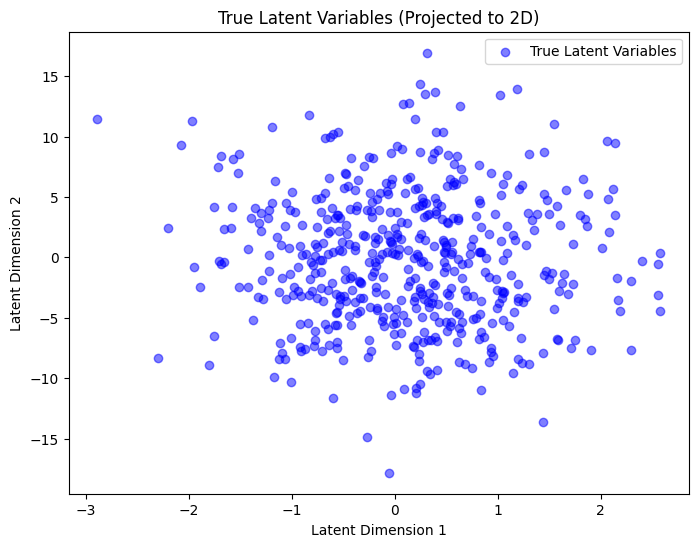

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def generate_complex_data(n_samples=1000, n_features=10, latent_dims=3, noise=0.1):
    """
    Generate synthetic data with multiple distinct dimensions of variance.
    
    Parameters:
    - n_samples: Number of data points.
    - n_features: Number of features (original dimensionality).
    - latent_dims: Number of true latent dimensions.
    - noise: Standard deviation of Gaussian noise added to the data.

    Returns:
    - data: Generated data of shape (n_samples, n_features).
    - true_latent: Latent variables of shape (n_samples, latent_dims).
    """
    np.random.seed(42)

    # Generate latent variables with distinct variances
    latent_variances = np.linspace(1, 10, latent_dims)
    true_latent = np.random.randn(n_samples, latent_dims) * latent_variances

    # Create a random projection matrix to embed latent variables in higher dimensions
    projection_matrix = np.random.randn(n_features, latent_dims)
    projection_matrix /= np.linalg.norm(projection_matrix, axis=0)  # Normalize columns

    # Project latent variables to higher dimensions
    high_dim_data = true_latent @ projection_matrix.T

    # Add Gaussian noise
    noise_matrix = np.random.normal(scale=noise, size=(n_samples, n_features))
    data = high_dim_data + noise_matrix

    return data, true_latent

# Generate data
n_samples = 500
n_features = 10
latent_dims = 3
data, true_latent = generate_complex_data(
    n_samples=n_samples, n_features=n_features, latent_dims=latent_dims, noise=0.2
)

# Visualize true latent structure (projected to 2D)
plt.figure(figsize=(8, 6))
plt.scatter(true_latent[:, 0], true_latent[:, 1], c='blue', alpha=0.5, label="True Latent Variables")
plt.title("True Latent Variables (Projected to 2D)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()


Converged after 49 iterations.


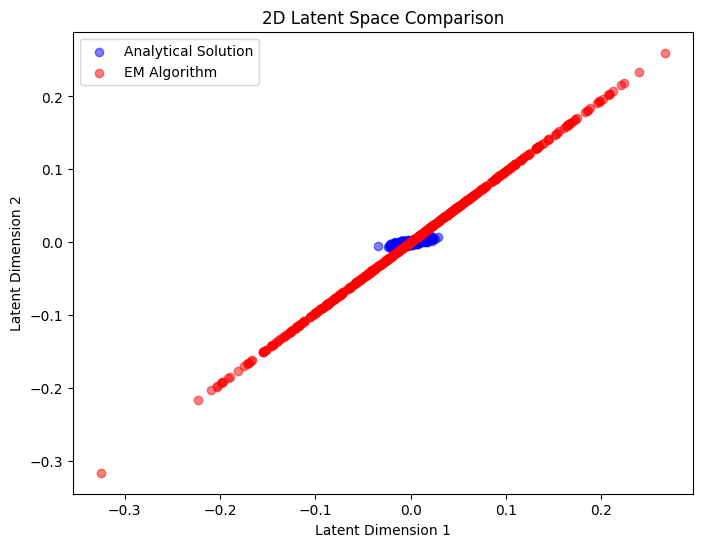

In [95]:
q = 3  # Match the true latent dimensionality

# Analytical PPCA
ppca_analytical = PPCA(n_components=q, max_iter=1, tol=1e-6)  # Mimic analytical solution
Z_analytical = ppca_analytical.fit_transform(data)

# EM-PPCA
ppca_em = PPCA(n_components=q, max_iter=100, tol=1e-6, verbose=True, random_state=42)
Z_em = ppca_em.fit_transform(data)

# Visualize latent space
plt.figure(figsize=(8, 6))
plt.scatter(Z_analytical[:, 0], Z_analytical[:, 1], c='blue', alpha=0.5, label="Analytical Solution")
plt.scatter(Z_em[:, 0], Z_em[:, 1], c='red', alpha=0.5, label="EM Algorithm")
plt.title("2D Latent Space Comparison")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()


In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class MixtureOfPPCA:
    def __init__(self, n_components, n_latent_dims, max_iter=100, tol=1e-4):
        """
        Initialize the Mixture of PPCA model.

        Parameters:
        - n_components: int, number of PPCA components in the mixture.
        - n_latent_dims: int, number of latent dimensions (q).
        - max_iter: int, maximum number of iterations for the EM algorithm.
        - tol: float, convergence tolerance for the log-likelihood.
        """
        self.n_components = n_components
        self.n_latent_dims = n_latent_dims
        self.max_iter = max_iter
        self.tol = tol
        
        # Initialize parameters
        self.weights = None
        self.means = None
        self.covars = None
        self.latent_covars = None

    def _initialize_parameters(self, X):
        """Randomly initialize parameters for the mixture model."""
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covars = np.array([np.eye(n_features) for _ in range(self.n_components)])
        self.latent_covars = np.array([np.eye(self.n_latent_dims) for _ in range(self.n_components)])

    def _e_step(self, X):
        """Expectation step: compute responsibilities."""
        n_samples, n_features = X.shape
        log_resps = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            diff = X - self.means[k]
            covar_k = self.covars[k]
            log_det_covar_k = np.log(np.linalg.det(covar_k))
            inv_covar_k = np.linalg.inv(covar_k)

            log_resps[:, k] = (
                -0.5 * (np.sum(diff @ inv_covar_k * diff, axis=1) + log_det_covar_k)
                + np.log(self.weights[k])
            )

        # Normalize log responsibilities using the log-sum-exp trick
        max_log_resps = np.max(log_resps, axis=1, keepdims=True)
        log_resps -= max_log_resps
        log_resps = np.exp(log_resps)
        log_resps /= np.sum(log_resps, axis=1, keepdims=True)

        return log_resps

    def _m_step(self, X, responsibilities):
        """Maximization step: update model parameters."""
        n_samples, n_features = X.shape
        effective_n = np.sum(responsibilities, axis=0)

        # Update weights
        self.weights = effective_n / n_samples

        # Update means
        self.means = np.dot(responsibilities.T, X) / effective_n[:, np.newaxis]

        # Update covariances and latent covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            resp_diag = np.diag(responsibilities[:, k])
            weighted_diff = diff.T @ resp_diag @ diff

            # Estimate the covariance
            self.covars[k] = weighted_diff / effective_n[k]

            # Decompose covariance matrix to estimate latent covariance
            eigenvalues, eigenvectors = np.linalg.eigh(self.covars[k])
            top_eigenvalues = eigenvalues[-self.n_latent_dims:]
            top_eigenvectors = eigenvectors[:, -self.n_latent_dims:]

            # Latent covariance and covariance reconstruction
            self.latent_covars[k] = np.diag(top_eigenvalues)
            self.covars[k] = (
                top_eigenvectors @ np.diag(top_eigenvalues) @ top_eigenvectors.T
                + np.eye(n_features) * (np.sum(eigenvalues[:-self.n_latent_dims]) / (n_features - self.n_latent_dims))
            )

    def fit(self, X):
        """Fit the Mixture of PPCA model using the EM algorithm."""
        self._initialize_parameters(X)

        log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            # E-step: compute responsibilities
            responsibilities = self._e_step(X)

            # M-step: update parameters
            self._m_step(X, responsibilities)

            # Compute log-likelihood
            new_log_likelihood = 0
            for k in range(self.n_components):
                diff = X - self.means[k]
                covar_k = self.covars[k]
                log_det_covar_k = np.log(np.linalg.det(covar_k))
                inv_covar_k = np.linalg.inv(covar_k)

                new_log_likelihood += np.sum(
                    responsibilities[:, k]
                    * (-0.5 * (np.sum(diff @ inv_covar_k * diff, axis=1) + log_det_covar_k))
                )

            # Check for convergence
            if np.abs(new_log_likelihood - log_likelihood) < self.tol:
                print(f"Converged at iteration {iteration}.")
                break

            log_likelihood = new_log_likelihood

    def predict(self, X):
        """Predict the component responsibilities for new data."""
        return self._e_step(X)


In [108]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go


class MixtureOfPPCA:
    def __init__(self, n_components, n_latent_dims, max_iter=100, tol=1e-4):
        """
        Initialize the Mixture of PPCA model.

        Parameters:
        - n_components: int, number of PPCA components in the mixture.
        - n_latent_dims: int, number of latent dimensions (q).
        - max_iter: int, maximum number of iterations for the EM algorithm.
        - tol: float, convergence tolerance for the log-likelihood.
        """
        self.n_components = n_components
        self.n_latent_dims = n_latent_dims
        self.max_iter = max_iter
        self.tol = tol
        
        # Initialize parameters
        self.weights = None
        self.means = None
        self.covars = None
        self.latent_covars = None

    def _initialize_parameters(self, X):
        """Randomly initialize parameters for the mixture model."""
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covars = np.array([np.eye(n_features) for _ in range(self.n_components)])
        self.latent_covars = np.array([np.eye(self.n_latent_dims) for _ in range(self.n_components)])

    def _e_step(self, X):
        """Expectation step: compute responsibilities."""
        n_samples, n_features = X.shape
        log_resps = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            diff = X - self.means[k]
            covar_k = self.covars[k]
            log_det_covar_k = np.log(np.linalg.det(covar_k))
            inv_covar_k = np.linalg.inv(covar_k)

            log_resps[:, k] = (
                -0.5 * (np.sum(diff @ inv_covar_k * diff, axis=1) + log_det_covar_k)
                + np.log(self.weights[k])
            )

        # Normalize log responsibilities using the log-sum-exp trick
        max_log_resps = np.max(log_resps, axis=1, keepdims=True)
        log_resps -= max_log_resps
        log_resps = np.exp(log_resps)
        log_resps /= np.sum(log_resps, axis=1, keepdims=True)

        return log_resps

    def _m_step(self, X, responsibilities):
        """Maximization step: update model parameters."""
        n_samples, n_features = X.shape
        effective_n = np.sum(responsibilities, axis=0)

        # Update weights
        self.weights = effective_n / n_samples

        # Update means
        self.means = np.dot(responsibilities.T, X) / effective_n[:, np.newaxis]

        # Update covariances and latent covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            resp_diag = np.diag(responsibilities[:, k])
            weighted_diff = diff.T @ resp_diag @ diff

            # Estimate the covariance
            self.covars[k] = weighted_diff / effective_n[k]

            # Decompose covariance matrix to estimate latent covariance
            eigenvalues, eigenvectors = np.linalg.eigh(self.covars[k])
            top_eigenvalues = eigenvalues[-self.n_latent_dims:]
            top_eigenvectors = eigenvectors[:, -self.n_latent_dims:]

            # Latent covariance and covariance reconstruction
            self.latent_covars[k] = np.diag(top_eigenvalues)
            self.covars[k] = (
                top_eigenvectors @ np.diag(top_eigenvalues) @ top_eigenvectors.T
                + np.eye(n_features) * (np.sum(eigenvalues[:-self.n_latent_dims]) / (n_features - self.n_latent_dims))
            )

    def fit(self, X):
        """Fit the Mixture of PPCA model using the EM algorithm."""
        self._initialize_parameters(X)

        log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            # E-step: compute responsibilities
            responsibilities = self._e_step(X)

            # M-step: update parameters
            self._m_step(X, responsibilities)

            # Compute log-likelihood
            new_log_likelihood = 0
            for k in range(self.n_components):
                diff = X - self.means[k]
                covar_k = self.covars[k]
                log_det_covar_k = np.log(np.linalg.det(covar_k))
                inv_covar_k = np.linalg.inv(covar_k)

                new_log_likelihood += np.sum(
                    responsibilities[:, k]
                    * (-0.5 * (np.sum(diff @ inv_covar_k * diff, axis=1) + log_det_covar_k))
                )

            # Check for convergence
            if np.abs(new_log_likelihood - log_likelihood) < self.tol:
                print(f"Converged at iteration {iteration}.")
                break

            log_likelihood = new_log_likelihood

    def predict(self, X):
        """Predict the component responsibilities for new data."""
        return self._e_step(X)


In [112]:

if __name__ == "__main__":
    # Generate synthetic 3D data
    np.random.seed(42)
    n_samples = 300
    n_features = 3
    n_components = 3
    n_latent_dims = 1

    # Create three clusters of data
    cluster_means = [np.random.rand(n_features) * 10 for _ in range(n_components)]
    cluster_covars = [np.eye(n_features) * np.random.rand() for _ in range(n_components)]

    X = np.vstack([
        np.random.multivariate_normal(cluster_means[k], cluster_covars[k], size=n_samples // n_components)
        for k in range(n_components)
    ])

    # Fit the Mixture of PPCA model
    model = MixtureOfPPCA(n_components=n_components, n_latent_dims=n_latent_dims)
    model.fit(X)

    # Predict responsibilities
    responsibilities = model.predict(X)

    # Assign each sample to the most likely component
    labels = np.argmax(responsibilities, axis=1)

    # Interactive 3D plot with Plotly
    fig = go.Figure()

    colors = ['red', 'green', 'blue']

    for k in range(n_components):
        cluster_data = X[labels == k]
        fig.add_trace(go.Scatter3d(
            x=cluster_data[:, 0],
            y=cluster_data[:, 1],
            z=cluster_data[:, 2],
            mode='markers',
            marker=dict(size=5, color=colors[k], opacity=0.8),
            name=f"Cluster {k+1}"
        ))

        # Plot the local principal components as lines
        mean_k = model.means[k]
        eigenvalues, eigenvectors = np.linalg.eigh(model.covars[k])
        top_eigenvector = eigenvectors[:, -1]  # Principal direction

        # Create a line along the principal component
        line_start = mean_k - 5 * top_eigenvector
        line_end = mean_k + 5 * top_eigenvector

        fig.add_trace(go.Scatter3d(
            x=[line_start[0], line_end[0]],
            y=[line_start[1], line_end[1]],
            z=[line_start[2], line_end[2]],
            mode='lines',
            line=dict(color=colors[k], width=5),
            name=f"PC Cluster {k+1}"
        ))

    fig.update_layout(
        title="3D Mixture of PPCA with Local Principal Components",
        scene=dict(
            xaxis_title="Feature 1",
            yaxis_title="Feature 2",
            zaxis_title="Feature 3",
        ),
        legend=dict(x=0.1, y=0.9),
    )

    fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [111]:
! pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any.whl.metadata (2.8 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl (18 kB)
Using cached referencing-0.35.1-py3-none-any.whl (26 kB)
